Antoine Sutter

First off, we import all the things we need

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Callable

Now here are the helper functions we will use for the program, stuff to generate array, neighbors, compute generic fitness functions and so on:

In [454]:
def generate_bits(n: int) -> np.array:
    """
    Generates an array of size n of random bits
    """
    return np.random.randint(2, size=n)


x = generate_bits(4)
x

array([1, 0, 1, 1])

In [515]:
def generate_neighbors(x: np.array) -> np.array:
    """
    Generate an array of size x.size where each element is a copy of the bitarray
    x but where one bit if flipped from the original. Those are the neighbors of x.
    
    if x = [0,0,1]
    returns [[0,0,0], [0,1,1], [1,0,1]]
    """
    return np.array([
        [
            (x[a] + 1) % 2 if a == i else x[a]
            for a in range(x.size)
        ]
        for i in range(x.size)
    ])


n = generate_neighbors(x)
n

array([[0, 0, 1, 1],
       [1, 1, 1, 1],
       [1, 0, 0, 1],
       [1, 0, 1, 0]])

In [463]:
def create_slided_chunks_array(x: np.array, k: int) -> np.array:
    """
    Slides a window of size K over and array and returns
    an array of arrays of size K
    
    if x = [0,0,1,0] and k = 2
    returns [[0,0], [0,1], [1,0]]
    """
    return np.array([
        x[i:i + k]
        for i in range(x.size - k + 1)
    ])


chunks = create_slided_chunks_array(x, 2)
chunks

array([[1, 0],
       [0, 1],
       [1, 1]])

Then all the fitness functions. `f_example` was only used as a reference to test the implementation of the upcoming functions. Note that in the slides, we mention `K` starts from 0 but in code, things are easier if `K` starts at 1.

In [466]:
def compute_f(x: np.array, k: int, fitness_dict: dict[str, int]) -> int:
    """
    Given a fitness dictionary, converts each bit chunk to a string and sums
    all the values for all chunks
    """
    chunks = create_slided_chunks_array(x, k)

    return np.sum([
        fitness_dict["".join(map(str, chunk))]
        for chunk in chunks
    ])


def f_example(x: np.array) -> int:
    """
    This is the example fitness function from the pdf
    """
    return compute_f(x, k=2, fitness_dict={
        "00": -1,
        "01": 1,
        "10": 1,
        "11": -1
    })


def f0(x: np.array) -> int:
    return compute_f(x, k=1, fitness_dict={
        "0": 2,
        "1": 1
    })


def f1(x: np.array) -> int:
    return compute_f(x, k=2, fitness_dict={
        "00": 2,
        "01": 3,
        "10": 2,
        "11": 0
    })


def f2(x: np.array) -> int:
    return compute_f(x, k=3, fitness_dict={
        "000": 0,
        "001": 1,
        "010": 1,
        "011": 0,
        "100": 2,
        "101": 0,
        "110": 0,
        "111": 0,
    })


f0(x), f1(x), f2(x)

(np.int64(5), np.int64(5), np.int64(0))

Now for the arguably easier Deterministic Hill-Climbing method. This method receives a bitarray. It then computes the fitness function for itself and for all if its neighbors. If its own result is better than any of its neighbors, then we found the best solution and can exit the function. However if one or more of its neighbors are better, we pick it instead and call the function recursively with the neighbor as the new starting value. This will keep checking for neighbors until eventually it finds the best solution. When K is 0, this will find the perfect solution every time. However for bigger Ks, we could get stuck on a local maxima and never find an existing better solution.

In [472]:
def dhc(x: np.array, fitness_function: Callable[[np.array], int]) -> [np.array, int]:
    initial_f = fitness_function(x)
    neighbors = generate_neighbors(x)
    neighbors_results = [(n, fitness_function(n)) for n in neighbors]
    sequence, f_result = max(neighbors_results, key=lambda n: n[1])

    if f_result > initial_f:
        # One of my neighbor is better, let's use it as a base for a new search
        return dhc(sequence, fitness_function)

    # no neighbor is better than x
    return x, initial_f



(array([0, 1, 0, 1, 1, 0, 1, 0, 1, 0]), np.int64(7))

If we try with the example function, the result should find either 01 or 10 repeating, for a fitness result of 9. However if you run this multiple times, we might get unlucky and it might not find it

In [500]:
dhc(generate_bits(10), fitness_function=f_example)

(array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1]), np.int64(9))

For a K of 0 (1 in code) it does though, for example `f0` will always work:

In [488]:
dhc(generate_bits(21), fitness_function=f0)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 np.int64(42))

Instead we can try Probabilistic Hill-Climbing. This will instead compute the probability of each neighbor of being correct and then do a weighted random pick. This process runs a defined amount of iterations before stopping and whatever is best at the time is the result. While this approach might not give the best answer, it has the benefit of not getting stuck on local maxima by choosing a neighbor at random.

Note: the pdf says the following:

> In addition, implement this method with an aspiration process, such that a neighbor that has a better fitness than the current best-explored solution, is always selected

This is done by keeping track of both the probability and the fitness result of a given random neighbor pick. If the random neighbor chosen has a worse fitness result than the current best result we found, we just roll again.

In [631]:
def phc(x: np.array, fitness_function: Callable[[np.array], int], max_iterations: int = 50) -> [np.array, int]:
    assert max_iterations > 0

    def pick_neighbor(neighbors: np.array) -> [np.array, int]:
        """
        Pick a random neighbor using weighted probabilities with the roulette technique
        """
        fitness_results = [fitness_function(neighbor) for neighbor in neighbors]
        fitness_total = np.sum(fitness_results)
        probabilities = [f / fitness_total for f in fitness_results]
        probabilities_sum = np.sum(probabilities)
        normalized_probabilities = [probability * 1 / probabilities_sum for probability in probabilities]
        cumulative_probabilities = np.cumsum(normalized_probabilities)

        r = np.random.rand()

        for i, j in enumerate(cumulative_probabilities):
            if r < j:
                return neighbors[i], fitness_results[i]

        raise Exception("this should never happen")

    def inner(x: np.array, current_best_x: np.array, current_best_f: int, iterations_left: int) -> [np.array, int]:
        """
        This is an inner recursive function used to hide the iteration parameter
        from the outside
        """
        if iterations_left == 0:
            # we can't do better than that
            return current_best_x, current_best_f

        neighbors = generate_neighbors(x)
        chosen, chosen_f = pick_neighbor(neighbors)

        if chosen_f > current_best_f:
            # aspiration process, only chose the random pick if its fitness function is better
            return inner(chosen, chosen, chosen_f, iterations_left=iterations_left - 1)

        # else just try again
        return inner(x, current_best_x, current_best_f, iterations_left=iterations_left - 1)

    # actual recursive call
    return inner(x, current_best_x=x, current_best_f=fitness_function(x), iterations_left=max_iterations)


x = generate_bits(10)
x, phc(x, fitness_function=f1)

(array([0, 1, 0, 0, 0, 1, 1, 1, 0, 0]),
 (array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1]), np.int64(23)))

Now to be able to judge of the stability of the results, as suggested in the pdf we will use the Hamming distance algorythm. 

In [513]:
def hamming_distance(a: np.array, b: np.array) -> int:
    assert a.size == b.size

    return np.sum([
        1 if a[i] != b[i] else 0
        for i in range(a.size)
    ])


# should be 2
hamming_distance(np.array([0, 0, 0, 0]), np.array([0, 1, 0, 1]))

np.int64(2)

Now we will prepare to graph stuff with this helper wrapper function. It does not take K as a parameter but a fitness function instead. This function is already tuned to work with some K though so it all works out the same.

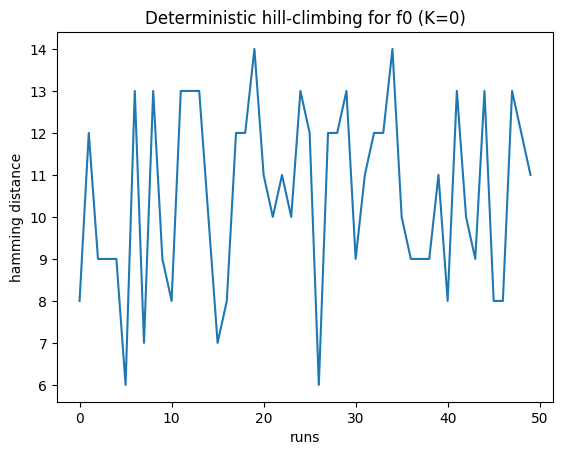

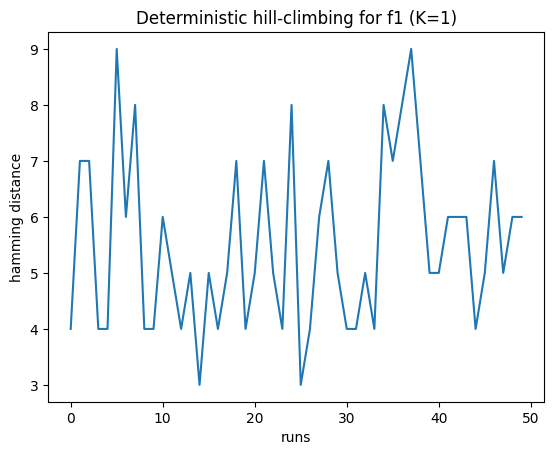

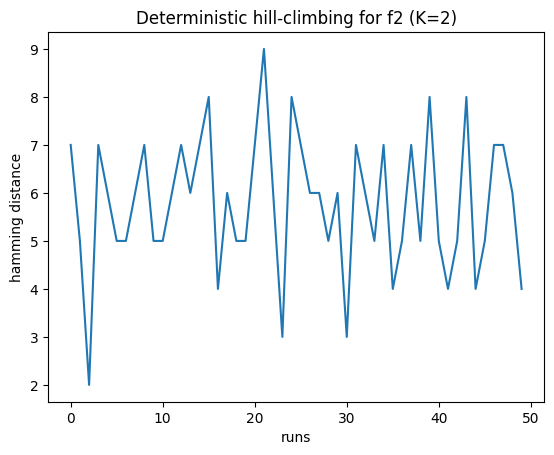

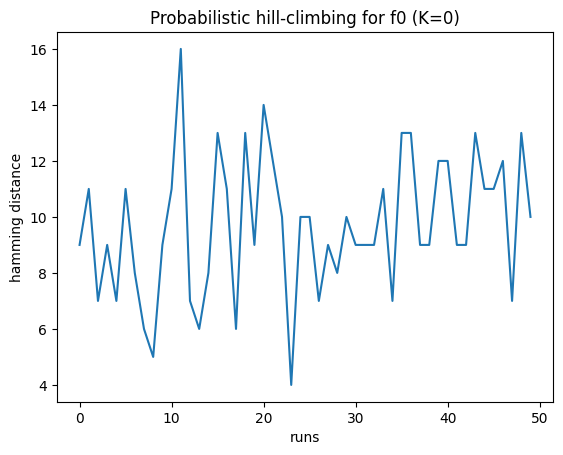

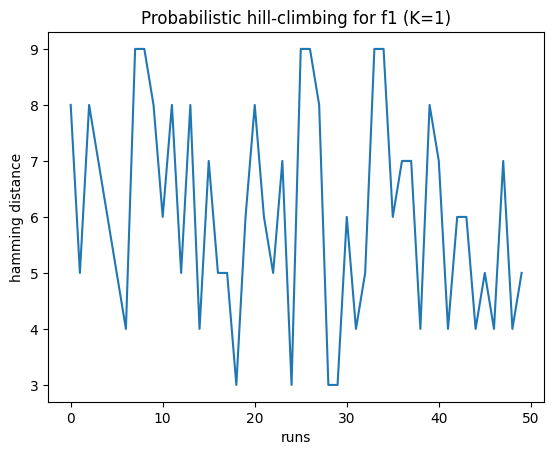

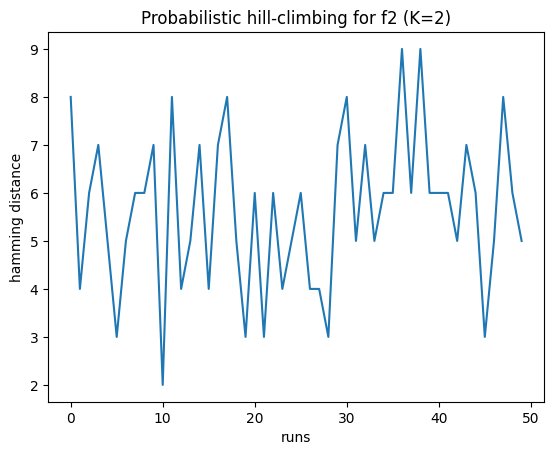

In [632]:
BitMap = np.array
FitnessFunction = Callable[[BitMap], int]
Algorythm = Callable[[BitMap, FitnessFunction], [BitMap, float | int]]


def get_hamming_distance_for_random_run(fitness_function: FitnessFunction, algorythm: Algorythm) -> int:
    x = generate_bits(21)
    result, fitness_result = algorythm(x, fitness_function=fitness_function)
    return hamming_distance(x, result)


fitness_functions = [
    ("f0 (K=0)", f0),
    ("f1 (K=1)", f1),
    ("f2 (K=2)", f2),
]

algorythms = [
    ("Deterministic hill-climbing", dhc),
    ("Probabilistic hill-climbing", phc),
]

for algorythm_name, algorythm in algorythms:
    for fitness_function_name, fitness_function in fitness_functions:
        distances = [
            get_hamming_distance_for_random_run(fitness_function=fitness_function, algorythm=algorythm)
            for _ in range(50)
        ]

        plt.ylabel("hamming distance")
        plt.xlabel("runs")
        plt.title(f"{algorythm_name} for {fitness_function_name}")
        plt.plot(distances)
        plt.show()



# 1. What is the roughness of the landscape ?

It seems pretty rough as the hamming distances greatly vary from one run to another. As far as I understand it, a smooth landscape would produce on average more similar hamming distances from one another.

# 2. What is the research space of the employed optimization methods ?

For a starting element of lenght N, it's all the bitarrays of size N or `{0,1}^N`

# 3. How are the two methods different ?

The deterministic method has the benefit of being able to find the best solution when K=0. It is also predictible and will always return the same result for a given input. However, it will find the closest maxima and will get stuck there. If that happen to not be the actual bext maxima, you are out of luck.

The probabilistic method will do a weight random pick of its neighbors according to their fitness functions. This has the advantage of avoiding getting stuck at a local maxima but requires a few iterations to have confidence in your result. However even after n iterations, you cannot be sure you have found the maxima as maybe you might have gotten a better result if you ran the algorythm longer. It is a nice tradeoff especially when your research space is very unstable and where a deterministic approach has a high probability of getting stuck in a local maxima.

# 4. What is the neighborhood of an element of the research space ?

The neighborhood is all the elements that differ by one bit from the element.

# 5. Is the solution of the optimization an element belonging to the re-search space or the fitness space ?

The research space as by definition it needs to be in the research space to be potentially found by the algorythms.
